In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv('../data/df.csv')

In [3]:
df

,source,embedding,genres
0,0,"[1.1568369, 4.7216134, -4.829661, 2.67412, 4.1...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,5,"[0.3488815, 6.3227067, -3.6201174, -0.45922923...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,7,"[-0.07164516, 4.885974, -5.827049, -0.01449445...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,8,"[0.10417974, -3.2304595, 3.5939155, 1.1410666,...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,11,"[-1.383354, 1.648171, -3.7612596, -1.3233246, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
9120,9140,"[0.28404692, 0.21873271, -0.3254155, 1.6711218...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
9121,9141,"[-0.8980954, -1.6762947, -1.2756481, 0.9909565...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
9122,9142,"[0.6182944, -0.6889125, -0.38154954, 1.0363413...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
9123,9143,"[1.9886293, 1.4495139, 1.4017138, 0.2425547, 1...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
emb_cols = ['d' + str(i) for i in range(1, 101)]
genre_cols = ["Children",
"Animation",
"Romance",
"Musical",
"Thriller",
"Fantasy",
"War",
"Western",
"Crime",
"IMAX",
"Film-Noir",
"Comedy",
"Drama",
"Horror",
"Mystery",
"Documentary",
"Sci-Fi",
"Adventure",
"Action",
"(no genres listed)"]
genre_cols.reverse()
new_df = df.join(pd.DataFrame(df.genres.str.strip("[]").str.split(", ").tolist(), columns=genre_cols, index=df.index, dtype=int))
new_df = new_df.join(pd.DataFrame(new_df.embedding.str.strip("[]").str.split(", ").tolist(), columns=emb_cols, index=new_df.index, dtype=float))
new_df[genre_cols] = new_df[genre_cols].apply(pd.to_numeric, errors='raise')
new_df = new_df.drop(['embedding', 'genres'], axis=1)
data = new_df
del new_df

### 5. PyTorch NN

Transforming pandas dataframe to torch tensor and splitting data into train, validation and test sets

In [5]:
df_features = data[emb_cols]
df_target = data[genre_cols]
X = torch.Tensor(df_features.values).float()
y = torch.Tensor(df_target.values).float()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)

In [7]:
print("Shape of X_train: {}; shape of y_train: {}".format(X_train.shape,y_train.shape))
print("Shape of X_val: {}; shape of y_val: {}".format(X_val.shape,y_val.shape))
print("Shape of X_test: {}; shape of y_test: {}".format(X_test.shape,y_test.shape))

Shape of X_train: torch.Size([6592, 100]); shape of y_train: torch.Size([6592, 20])
Shape of X_val: torch.Size([1164, 100]); shape of y_val: torch.Size([1164, 20])
Shape of X_test: torch.Size([1369, 100]); shape of y_test: torch.Size([1369, 20])


Neural Net (2 layers and ReLu activation):

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, output_size):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size_1)
        self.layer2 = nn.Linear(hidden_size_1, output_size)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [9]:
net = Net(100, 140, 20)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-5)
loss_criterion = nn.MultiLabelSoftMarginLoss()
epochs = 100

Neural net training:

In [10]:
losses = []
losses_val = []
for epoch in range(epochs):
    y_predicted = net(X_train)
    loss = loss_criterion(y_predicted, y_train)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred_val = net(X_val)
        losses_val.append(loss_criterion(y_pred_val, y_val))

Text(0, 0.5, 'MultiLabelSoftMarginLoss')

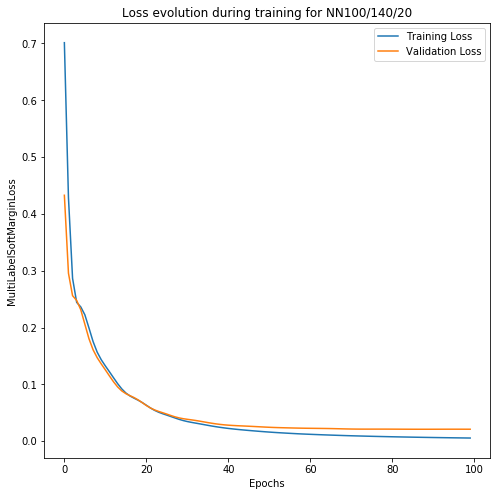

In [11]:
plt.figure(figsize=(8,8))
line_training = plt.plot(losses, label='Training Loss')
line_validation = plt.plot(losses_val, label='Validation Loss')
plt.title("Loss evolution during training for NN100/140/20")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MultiLabelSoftMarginLoss')

#### Model Evaluation:

In [12]:
from sklearn.metrics import multilabel_confusion_matrix, label_ranking_average_precision_score

In [13]:
y_test_pred = net(X_test)

In [14]:
def probs_to_labels(y_elem):
    if y_elem > 0: return 1
    else: return 0
probs_to_labels_vec = np.vectorize(probs_to_labels)

In [16]:
multilabel_confusion_matrix(probs_to_labels_vec(y_test_pred.detach().numpy()), y_test.numpy())

array([[[1366,    0],
        [   0,    3]],

       [[1138,    9],
        [   7,  215]],

       [[1202,    2],
        [   8,  157]],

       [[1290,    2],
        [   0,   77]],

       [[1279,    3],
        [   4,   83]],

       [[ 852,    6],
        [   8,  503]],

       [[1204,    5],
        [   6,  154]],

       [[1293,    2],
        [   0,   74]],

       [[ 708,   20],
        [  28,  613]],

       [[1255,    2],
        [   3,  109]],

       [[1342,    5],
        [   0,   22]],

       [[1229,    3],
        [   1,  136]],

       [[1347,    3],
        [   2,   17]],

       [[1297,    2],
        [   2,   68]],

       [[1284,    5],
        [   2,   78]],

       [[1123,    7],
        [   6,  233]],

       [[1246,    4],
        [   2,  117]],

       [[1103,   11],
        [  10,  245]],

       [[1309,    4],
        [   0,   56]],

       [[1343,    1],
        [   1,   24]]])

In [18]:
label_ranking_average_precision_score(probs_to_labels_vec(y_test_pred.detach().numpy()), y_test.numpy()) # greater than 0, best is 1

0.9606284856284849

### Saving the Model

In [63]:
PATH_TO_SAVE = '../data/model_torch'
torch.save(net.state_dict(), PATH_TO_SAVE)

### Testing with some movies

In [19]:
def get_movie_genres(df, id_movie):
    # Obtain true genres
    genres_true = df[df['source']==id_movie].genres.str.strip("[]").str.split(", ").tolist()
    genres_true = list(map(float,genres_true[0]))
    return genres_true

In [20]:
def predict_movie_genres(df, id_movie, model):
    # Obtain embedding for movie with id_movie
    emb = df[df['source']==id_movie].embedding.str.strip("[]").str.split(", ").tolist()
    emb = list(map(float,emb[0]))
    emb = torch.Tensor(emb).float()
    
    # Predict genres using model
    genres_predicted = model(emb)
    genres_predicted = probs_to_labels_vec(genres_predicted.detach().numpy())
    
    return genres_predicted

In [40]:
def label_to_genre(labels, genres):
    return np.array(genre_cols)[np.array(np.argwhere(labels).flatten())]

Test 1: 

In [75]:
movie_id_1 = 9123
labels_predicted_1 = predict_movie_genres(df, movie_id_1, net)
genres_predicted_1 = label_to_genre(labels_predicted_1, genre_cols)
genres_true_1 = label_to_genre(get_movie_genres(df, movie_id_1), genre_cols)
print("Predicted genres for movie with movie_id = {} are {}". format(movie_id_1, genres_predicted_1))
print("True genres for movie with movie_id = {} are {}". format(movie_id_1, genres_true_1))

Predicted genres for movie with movie_id = 9123 are ['Action' 'Adventure']
True genres for movie with movie_id = 9123 are ['Action' 'Adventure']


Test 2: 

In [76]:
movie_id_2 = 9124
labels_predicted_2 = predict_movie_genres(df, movie_id_2, net)
genres_predicted_2 = label_to_genre(labels_predicted_2, genre_cols)
genres_true_2 = label_to_genre(get_movie_genres(df, movie_id_2), genre_cols)
print("Predicted genres for movie with movie_id = {} are {}". format(movie_id_2, genres_predicted_2))
print("True genres for movie with movie_id = {} are {}". format(movie_id_2, genres_true_2))

Predicted genres for movie with movie_id = 9124 are ['Action' 'Crime' 'Musical']
True genres for movie with movie_id = 9124 are ['Action' 'Crime' 'Musical']


Test 3:

In [77]:
movie_id_3 = 9125
labels_predicted_3 = predict_movie_genres(df, movie_id_3, net)
genres_predicted_3 = label_to_genre(labels_predicted_3, genre_cols)
genres_true_3 = label_to_genre(get_movie_genres(df, movie_id_3), genre_cols)
print("Predicted genres for movie with movie_id = {} are {}". format(movie_id_3, genres_predicted_3))
print("True genres for movie with movie_id = {} are {}". format(movie_id_3, genres_true_3))

Predicted genres for movie with movie_id = 9125 are ['Mystery']
True genres for movie with movie_id = 9125 are ['Mystery']
